### Binary Classification Regression Machine Learning Modelling

In this project, we'll build different types of binary classification regression Machine Learning models to help predict bank clients that will churn according to the available data. We'll follow EDA (Exploratory Data Analysis) steps and finally utilize ensembling to compare different models and select the best one according to the metrics we find here.

Our database is public and is available on Kaggle: https://www.kaggle.com/datasets/rangalamahesh/bank-churn/data

In [72]:
import numpy as np
import pandas as pd

# This is the classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import PredefinedSplit

# This is the function that helps plot feature importance 
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# This displays all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# This module lets us save our models once we fit them.
import joblib 

In [73]:
df_train = pd.read_csv(f'train.csv')
df_train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [74]:
df_train.shape

(165034, 14)

In [75]:
df_train['Exited'].value_counts()

Exited
0    130113
1     34921
Name: count, dtype: int64

In [76]:
# Calculate average balance of customers who churned
avg_churned_bal = df_train[df_train['Exited']==1]['Balance'].mean()
print(f'U$ {avg_churned_bal:,.2f}')

U$ 71,209.98


In [77]:
# Drop useless and sensitive (Gender) cols, and split the data into target and predictor variables
df_train = df_train.drop(['CustomerId', 'Surname', 'Gender'], axis=1)

In [78]:
# Transforming categorical data into dummies
df_train = pd.get_dummies(df_train, drop_first=True)
df_train.head()

,id,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,0,668,33.0,3,0.00,2,1.0,0.0,181449.97,0,False,False
1,1,627,33.0,1,0.00,2,1.0,1.0,49503.50,0,False,False
2,2,678,40.0,10,0.00,2,1.0,0.0,184866.69,0,False,False
3,3,581,34.0,2,148882.54,1,1.0,1.0,84560.88,0,False,False
4,4,716,33.0,5,0.00,2,1.0,1.0,15068.83,0,False,True


In [79]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 165034 non-null  int64  
 1   CreditScore        165034 non-null  int64  
 2   Age                165034 non-null  float64
 3   Tenure             165034 non-null  int64  
 4   Balance            165034 non-null  float64
 5   NumOfProducts      165034 non-null  int64  
 6   HasCrCard          165034 non-null  float64
 7   IsActiveMember     165034 non-null  float64
 8   EstimatedSalary    165034 non-null  float64
 9   Exited             165034 non-null  int64  
 10  Geography_Germany  165034 non-null  bool   
 11  Geography_Spain    165034 non-null  bool   
dtypes: bool(2), float64(5), int64(5)
memory usage: 12.9 MB


In [80]:
# Downcast data to use less memory

for col in df_train.select_dtypes(include=['float64']).columns:
    df_train[col] = pd.to_numeric(df_train[col], downcast='float')

for col in df_train.select_dtypes(include=['int64']).columns:
    df_train[col] = pd.to_numeric(df_train[col], downcast='integer')

print(df_train.dtypes)

id                     int32
CreditScore            int16
Age                  float32
Tenure                  int8
Balance              float64
NumOfProducts           int8
HasCrCard            float32
IsActiveMember       float32
EstimatedSalary      float64
Exited                  int8
Geography_Germany       bool
Geography_Spain         bool
dtype: object


In [81]:
# Split the data into target and predictor variables

y = df_train['Exited']
X = df_train.copy()
X = X.drop("Exited", axis=1)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    stratify=y, random_state=42)

### Decision tree modelling

In [83]:
decision_tree = DecisionTreeClassifier(random_state=0)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

In [84]:
%%time
dt_pred = decision_tree.predict(X_test)

CPU times: total: 31.2 ms
Wall time: 12 ms


In [85]:
# We'll use joblib to save results so we don't have to retrain models everytime 
joblib.dump(dt_pred, 'decision_tree.joblib')

['decision_tree.joblib']

In [86]:
dt_pred = joblib.load('decision_tree.joblib')

In [87]:
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.793
Precision: 0.510
Recall: 0.532
F1 Score: 0.521



Let's inspect the confusion matrix of our decision tree's predictions. First, we'll write a short helper function to help us display the matrix.

In [88]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

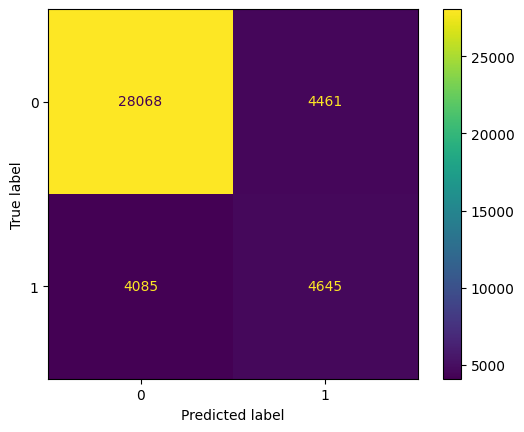

In [89]:
# Generate confusion matrix
conf_matrix_plot(decision_tree, X_test, y_test)

### Plotting the tree
Next, let's examine the splits of the tree. We'll do this by using the plot_tree() function that we imported. We pass to it our fit model as well as some additional parameters. Note that if we did not set max_depth=2, the function would return a plot of the entire tree, all the way down to the leaf nodes. This is intractable and unnecessary. We're most interested in the splits nearest the root, because these tell us the most predictive features.

class_names displays what the majority class of each node is, and filled colors the nodes according to their majority class.

Note that this plot represents how the tree grew from the training data. To make its predictions on the test data, the tree would simply pass each customer in the test data through its splits, from the root node all the way down to a leaf node.

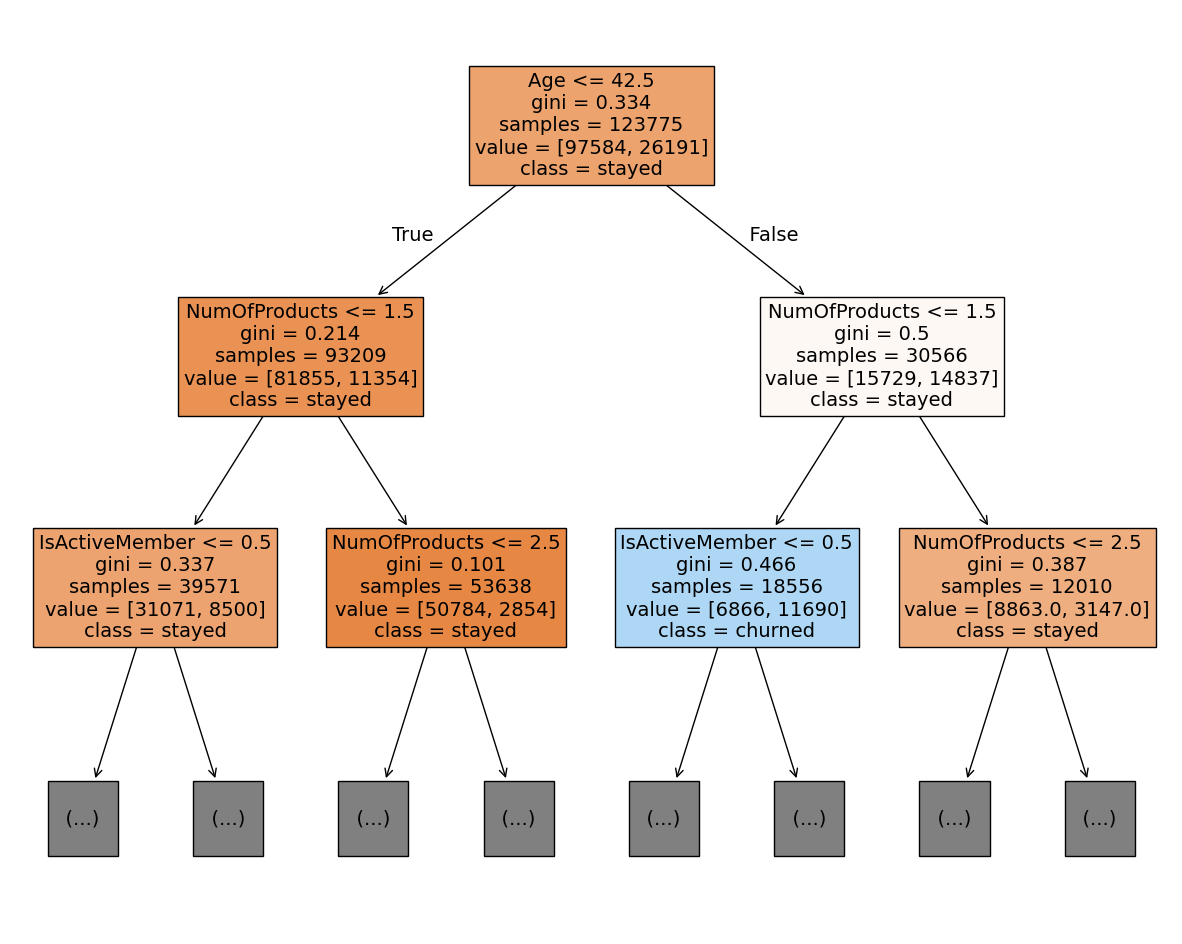

In [90]:
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=X.columns, 
          class_names={0:'stayed', 1:'churned'}, filled=True);
plt.show()

This plot tells us that, if we could only do a single split on a single variable, the one that would most help us predict whether a customer will churn is their age.

If we look at the nodes at depth one, we notice that the number of products and whether or not the customer is an active member also are both strong predictors (relative to the features we have) of whether or not they will churn.

This is a good indication that it might be worthwhile to return to your EDA and examine these features more closely.

---------------------------------------------------------

### Tune and validating decision tree

* This approach has a limitation. We are using the same data to tune the hyperparameters as we are using to perform model selection. This risks potentially overfitting the model to the validation data.

* Ideally, with enough time and data, we'd tune the models' hyperparameters, then score all the models on separate validation data and perform model selection based on these scores. Finally, the champion model would be scored on the test holdout data to get an estimate of how the model can be expected to perform on new, unseen data.

In [91]:
# Instantiate the classifier
tuned_decision_tree = DecisionTreeClassifier(random_state = 42)

tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

Create a set of scoring metrics to capture. These metrics can be selected from scikit-learn's built-in options or custom-defined. For this project, we'll capture accuracy, precision, recall, and F1 score so we can examine all of them. The metrics are entered as strings. We'll use j_jobs=-1 so Python will use all our of CPU cores to train the models, it can help train ML models faster.

In [92]:
# Instantiate the GridSearch
scoring = ['accuracy', 'precision', 'recall', 'f1']
clf = GridSearchCV(tuned_decision_tree, 
                   tree_para, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1",
                   n_jobs=-1)

In [93]:
%%time
#Fit the model
clf.fit(X_train, y_train)

CPU times: total: 5.14 s
Wall time: 26.3 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50],
                         'min_samples_leaf': [2, 5, 10, 20, 50]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [94]:
joblib.dump(clf, 'tuned_dt.joblib')

['tuned_dt.joblib']

In [95]:
clf = joblib.load('tuned_dt.joblib')

Now that the model is fit and cross-validated, we can use the best_estimator_ attribute to inspect the hyperparameter values that yielded the highest F1 score during cross-validation.

In [96]:
clf.best_estimator_

DecisionTreeClassifier(max_depth=6, min_samples_leaf=50, random_state=42)

In [97]:
print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

Best Avg. Validation Score:  0.6278


Although the F1 score of 0.561 is significantly better than the baseline model's F1 score of 0.494, it's not a fair comparison, because the baseline model was scored on the test data and the tuned model was scored against validation folds that came from the training data.

Recall that when we ran our grid search, we specified that we also wanted to capture precision, recall, and accuracy. The reason for doing this is that it's difficult to interpret an F1 score. These other metrics are much more directly interpretable, so they're worth knowing.

The following cell defines a helper function that extracts these scores from the fit GridSearchCV object and returns a pandas dataframe with all four scores from the model with the best average F1 score during validation. This function will help us later when we want to add the results of other models to the table.

In [98]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                          'F1': [f1],
                          'Recall': [recall],
                          'Precision': [precision],
                          'Accuracy': [accuracy]
                         }
                        )
  
    return table

In [99]:
dt_tuned_results = make_results("Tuned Decision Tree", clf)
dt_tuned_results

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.627788,0.551716,0.728343,0.861571


Random Forest Modelling
The cross-validation process is the same as it was for the decision tree model. The only difference is that we're tuning more hyperparameters now. 

In [100]:
rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [2,3,4,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }  

scoring = ['accuracy', 'precision', 'recall', 'f1']

rf_cv = GridSearchCV(rf, 
                   cv_params, 
                   scoring = scoring, 
                   cv=5, 
                   refit="f1",
                   n_jobs=-1)

In [101]:
%%time
rf_cv.fit(X_train, y_train)
rf_cv.best_params_

CPU times: total: 1min 10s
Wall time: 56min 47s


{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [102]:
joblib.dump(rf_cv, 'rf_cv.joblib')

['rf_cv.joblib']

And to check the best average F1 score of this model on the validation folds, we can use the best_score_ attribute. Remember, if we had instead set refit=recall when we instantiated our GridSearchCV object earlier, then calling best_score_ would return the best recall score, and the best parameters might not be the same as what they are in the above cell, because the model would be optimizing for a different metric.

In [103]:
print("Best Avg. Validation Score: ", "%.4f" % rf_cv.best_score_)

Best Avg. Validation Score:  0.6200


### Hyperparameters tuned with separate validation set  
We'll use `train_test_split` to divide `X_train` and `y_train` into 80% training data (`X_tr`, `y_tr`) and 20% validation data (`X_val`, `y_val`). 

In [104]:
# Create separate validation data
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                            stratify=y_train, random_state=10)

In [105]:
# Create list of split indices
split_index = [0 if x in X_val.index else -1 for x in X_train.index]

In [106]:
random_forest_val = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [2,3,4,5, None], 
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
             }  

scoring = ['accuracy', 'precision', 'recall', 'f1']

custom_split = PredefinedSplit(split_index)

rf_val = GridSearchCV(random_forest_val, 
                   cv_params, 
                   scoring = scoring, 
                   cv = custom_split, 
                   refit="f1",
                   n_jobs=-1)

In [107]:
%%time
rf_val.fit(X_train, y_train)

CPU times: total: 40.8 s
Wall time: 11min 44s


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
             estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 125, 150]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [108]:
joblib.dump(rf_val, 'rf_val.joblib')

['rf_val.joblib']

In [109]:
rf_val = joblib.load('rf_val.joblib')

In [110]:
rf_val.best_params_

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 150}

XGB Modelling

The process is basically the same, although we'll be using different CV paramaters.

In [111]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0) 

cv_params = {'max_depth': [4,5,6,7,8], 
             'min_child_weight': [1,2,3,4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 125]
             }    

scoring = ['accuracy', 'precision', 'recall', 'f1']

xgb_cv = GridSearchCV(xgb,
                    cv_params,
                    scoring = scoring,
                    cv=5, 
                    refit='f1', 
                    n_jobs=-1)

In [112]:
%%time
xgb_cv.fit(X, y)

CPU times: total: 14.3 s
Wall time: 5min 22s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [4, 5, 6, 7, 8],
                         'min_child_weight': [1, 2, 3, 4, 5],
                         'n_estimators': [75, 100, 125]},
             refit='f1', scoring=['accuracy', 'precision', 'recall', 'f1'])

In [113]:
joblib.dump(xgb_cv, 'xgb_cv.joblib')

['xgb_cv.joblib']

In [114]:
xgb_cv = joblib.load('xgb_cv.joblib')

In [120]:
dt_tuned_results = make_results("Tuned Decision Tree", clf)
rf_cv_results = make_results("Random Forest CV", rf_cv)
rf_val_results = make_results("Random Forest Validated", rf_val)
XGB_results = make_results("XGBoost", xgb_cv)

In [126]:
results = pd.concat([dt_tuned_results, rf_cv_results, rf_val_results, XGB_results]).sort_values(by='F1', ascending=False)
results

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decision Tree,0.627788,0.551716,0.728343,0.861571
0,Random Forest Validated,0.621244,0.538755,0.733559,0.860998
0,Random Forest CV,0.619966,0.538162,0.731102,0.860392
0,XGBoost,0.609701,0.519601,0.749407,0.860598


Based on the analysis of the metrics, the Tuned Decision Tree model appears to be the best option, as it has the best performance in F1-Score, Recall, and Accuracy.

---------------------------------------

### A few steps to consider after all the modeling that may be worth checking and redoing throught EDA steps, and reassessing the results:

* Re-model with the gender column included again.
* Analyze feature correlations, as binary logistic regression can be sensitive to correlations and affect our results.
* Check feature relevance to determine if we can drop them to improve both performance and results."